# n-Armed Bandit Problem

The problem statement is as follows, consider number of levers on slot machine for example. Each lever has a reward but the agent can only estimate the value of reward it receives. After some trial and errors agent should pick a lever that gives him the most reward. 

The question that might arise is that how should we keep the balance between exploiting (picking the lever that we think is the best) and exploring (pulling other levers to gain better estimation).


## Action-Value Method

The first approach to this problem is to take an action-value method, this means that giving value to each action so that we could keep track of each action and decide whether choosing them or not in the future. Here we do it by averaging enough samples so that by the rule of big numbers the estimation will approach the real value, and then choose the best estimation.

In [31]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import pow, e
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 8)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class Environment():
    
    def __init__(self, armCount = 10, mean = 0.0, stdev = 1.0):
        
        self.armCount = armCount
        self.arms = np.arange(armCount)
        
        self.qStar = np.random.normal(mean, stdev, armCount)
        self.optimalChoice = np.argmax(self.qStar)
            
    def reward(self, choosen):
        return self.qStar[choosen] + np.random.rand() 

In [3]:
env = Environment()

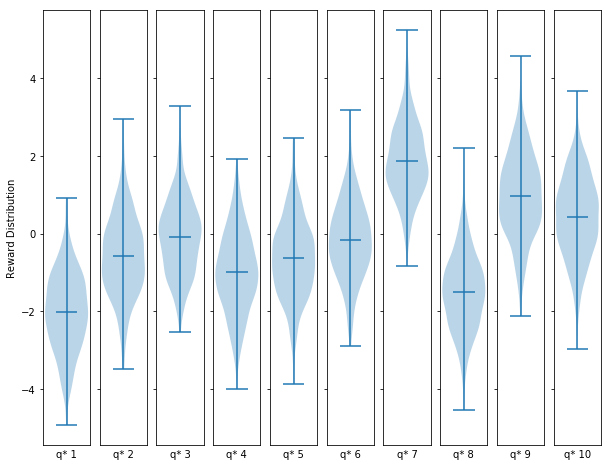

In [25]:
fig, axes = plt.subplots(1, env.armCount, sharey=True)
axes = axes.ravel()

for k, v in enumerate(env.qStar):
    ax = axes[k]
    ax.set_xticks([])
    data = np.random.normal(v, size=500)
    ax.violinplot(data, showmeans=True)
    ax.set_xlabel('q* ' + str(k + 1))
    if k == 0: ax.set_ylabel('Reward Distribution')

In [5]:
class GreedyAgent():
    
    def __init__(self, armCount):
        self.values = np.zeros(armCount) # estimated reward of each action
        self.pullCount = np.zeros(armCount) # number of pull for each lever
        self.armCount = armCount # number of arms

    def __repr__(self):
        return "Greedy"

    def selectArm(self):
        return np.argmax(self.values)

    def update(self, i, reward):
        self.pullCount[i] += 1
        count = self.pullCount[i]
        value = self.values[i]
        # newEstimate = oldEstimate + step_size * (target - oldEstimate)
        self.values[i] = value + (1/count) * (reward - value)

    def refresh(self):
        self.values.fill(0)
        self.pullCount.fill(0)
    

In [78]:
agents = [GreedyAgent(env.armCount)]

In [6]:
class Sampling():
    
    armCount = 10
    play = 1000
    run = 2000
    
    def __init__(self, env, agents, play = 1000, run = 2000):
        self.env = env
        self.agents = agents
        self.play = play
        self.run = run
        self.colors = ['blue', 'red', 'green', 'magenta', 'cyan']
        self.rewardData = np.zeros((len(agents), play, run))
        self.optimalityData = np.zeros((len(agents), play, run))
        
    def start(self):
        
        for r in tqdm(range(self.run)):
            for p in range(self.play):
                for a in range(len(self.agents)):
                    choosen = self.agents[a].selectArm()
                    reward = self.env.reward(choosen)
                    self.agents[a].update(choosen, reward)
                    self.rewardData[a][p][r] += reward
                    if self.env.optimalChoice == choosen:
                        self.optimalityData[a][p][r] += 1
        
            for a in range(len(agents)):
                self.agents[a].refresh()

        

In [80]:
sample = Sampling(env, agents)
sample.start()

100%|██████████| 2000/2000 [00:15<00:00, 129.78it/s]


In [17]:
def plotResults(sample):
    rewardMean = np.mean(sample.rewardData, axis=2)
    optimalityMean = np.mean(sample.optimalityData, axis=2)
    time = np.array(list(range(sample.play)))

    for a in range(len(sample.agents)):
        plt.subplot(2, 1, 1)
        plt.plot(time, optimalityMean[a], '-o'
                , color=sample.colors[a], markersize=0.7, lw=1.5, label=str(sample.agents[a]))
        plt.ylabel('% Optimal Action')

        plt.subplot(2, 1, 2)
        plt.plot(time, rewardMean[a], '-o'
                , color=sample.colors[a], markersize=0.7, lw=1.5, label=str(sample.agents[a]))
        plt.ylabel('Average Reward')
        plt.xlabel('play')

    plt.legend(loc='best', fancybox=True)
    plt.show()

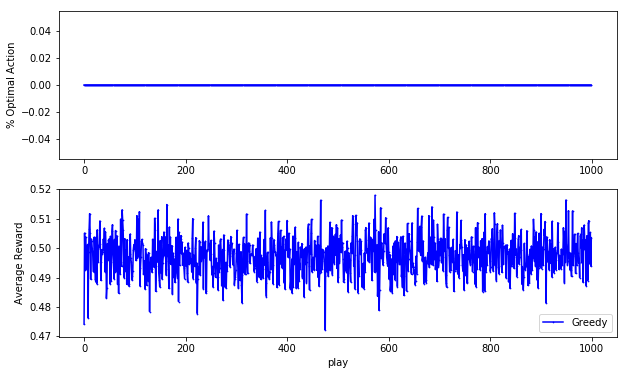

In [82]:
plotResults(sample)

why this agent is doing so poorly is because it just thinks that the first action is the best and always exploit it and never explore other options. The simple solution is to define a new agent that explore with the probabilty of epsilon.

In [8]:
class EpsilonGreedyAgent():
    
    def __init__(self, armCount, epsilon = 0.1):
        self.values = np.zeros(armCount)
        self.pullCount = np.zeros(armCount)
        self.choice = np.arange(armCount)
        self.armCount = armCount
        self.epsilon = epsilon

    def __repr__(self):
        return "Epsilon= " + str(self.epsilon)

    def selectArm(self):
        if np.random.rand() > self.epsilon: # Exploit
            return np.argmax(self.values)
        else: # Explore
            return np.random.choice(self.choice)

    def update(self, i, reward):
        self.pullCount[i] += 1
        count = self.pullCount[i]
        value = self.values[i]
        # newEstimate = oldEstimate + step_size * (target - oldEstimate)
        self.values[i] = value + (1/count) * (reward - value)

    def refresh(self):
        self.values.fill(0)
        self.pullCount.fill(0)

In [28]:
agents = [EpsilonGreedyAgent(env.armCount, 0.01), EpsilonGreedyAgent(env.armCount, 0.04), GreedyAgent(env.armCount)]
sample = Sampling(env, agents)
sample.start()

100%|██████████| 2000/2000 [00:45<00:00, 43.93it/s]


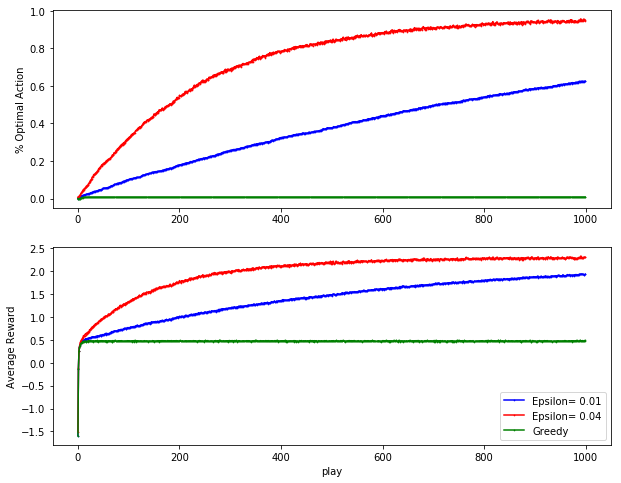

In [29]:
plotResults(sample)

One downside to this approch is that when it explores it chooses equally among all actions. This means that it is as likely to choose the worst-appearing action as it is to choose the next-to-best action. We can choose other options with probability based on their value.

## Softmax Action Selection

This approch is called softmax action selection rule, commin way to achive this is by using Boltzmann distribution.
Probability of choosing option a is:

\begin{equation*}
\frac{{e^{Q_t(a)}}/{\tau}}{\sum_{b=1}^n {e^{Q_t(b)}}/{\tau}}
\end{equation*}

where tau is a positive parameter called the temperature. High temperatures cause the actions to be all (nearly) equiprobable (it's like picking action one after another no matter what the reward is). Low temperatures cause a greater difference in selection probability(works nearly same as greedy agent). 

In [32]:
class SoftmaxAgent():
    
    def __init__(self, armCount, temp = 0.1):
        self.values = np.zeros(armCount)
        self.pullCount = np.zeros(armCount)
        self.choice = np.arange(armCount)
        self.armCount = armCount
        self.temp = temp
        self.valueExp = np.ones(armCount) # save e ^ value/temp
        self.sumExp = 1 * self.armCount # sum of all e ^ value/temp (in beggining all of them are 1)
        self.prob = self.valueExp / self.armCount 

    def __repr__(self):
        return "Softmax: " + str(self.temp)

    def selectArm(self):
        return np.random.choice(self.choice, p=self.prob) # choose arm according to its probability

    def update(self, i, reward):
        self.pullCount[i] += 1
        count = self.pullCount[i]
        value = self.values[i]
        # updating value estimation and probabilties
        self.sumExp -= self.valueExp[i]
        self.values[i] = value + (1/count) * (reward - value) #* (1 - prob)
        m = self.values[i] / self.temp
        self.valueExp[i] = pow(e,m)
        self.sumExp += self.valueExp[i]
        self.prob = self.valueExp / self.sumExp
        

    def refresh(self):
        self.values.fill(0)
        self.pullCount.fill(0)
        self.valueExp.fill(1.0)
        self.sumExp = 1 * self.armCount
        self.prob.fill(1/self.armCount)

In [33]:
agents = [SoftmaxAgent(env.armCount, 0.25), EpsilonGreedyAgent(env.armCount, 0.04), GreedyAgent(env.armCount)]
sample = Sampling(env, agents)
sample.start()

100%|██████████| 2000/2000 [02:20<00:00, 14.22it/s]


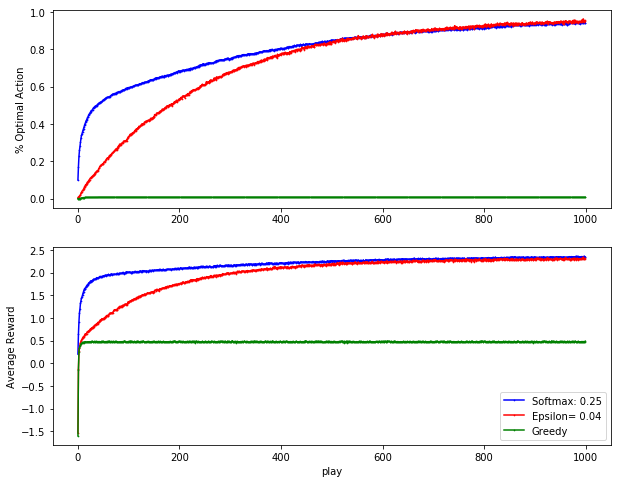

In [34]:
plotResults(sample)

This environment is stationary so optimistic greedy is doing better because it had found the best action in initial exploration 

## Constant Step Size

To this point we have used sample-average method to update our value estimation, but this is going to work only on a stationary problem. What if our environment change the value of reward slightly over time? The solution is to choose a constant step size (alpha) for our agent.

In [84]:
class NonStationaryEnvironment():
    
    def __init__(self, armCount = 10, mean = 0.0, stdev = 1.0, rate = 0.1):
        
        self.armCount = armCount
        self.arms = np.arange(armCount)
        
        self.rate = rate # rate of changing qStars
        self.qStar = np.random.normal(mean, stdev, armCount)
        self.optimalChoice = np.argmax(self.qStar)
            
    def reward(self, choosen):
        self.qStar[choosen] += self.rate*np.random.uniform(-0.1, 0.1)
        if(self.qStar[choosen] > self.optimalChoice): self.optimalChoice = choosen
        return self.qStar[choosen] + np.random.rand() 

In [85]:
nsEnv = NonStationaryEnvironment()

In [86]:
class EpsilonGreedyAgent2():
    
    def __init__(self, armCount, epsilon = 0.1, alpha = 0.1):
        self.values = np.zeros(armCount)
        self.pullCount = np.zeros(armCount)
        self.choice = np.arange(armCount)
        self.armCount = armCount
        self.epsilon = epsilon
        self.alpha = alpha

    def __repr__(self):
        return "Epsilon= " + str(self.epsilon) + " Alpha=  " + str(self.alpha)

    def selectArm(self):
        if np.random.rand() > self.epsilon: # Exploit
            return np.argmax(self.values)
        else: # Explore
            return np.random.choice(self.choice)

    def update(self, i, reward):
        self.pullCount[i] += 1
        count = self.pullCount[i]
        value = self.values[i]
        # newEstimate = oldEstimate + step_size * (target - oldEstimate)
        self.values[i] = value + (self.alpha) * (reward - value)

    def refresh(self):
        self.values.fill(0)
        self.pullCount.fill(0)

In [89]:
agents = [EpsilonGreedyAgent(env.armCount, 0.1), EpsilonGreedyAgent2(env.armCount, 0.1, 0.1)]
sample = Sampling(nsEnv, agents)
sample.start()

100%|██████████| 2000/2000 [00:44<00:00, 44.88it/s]


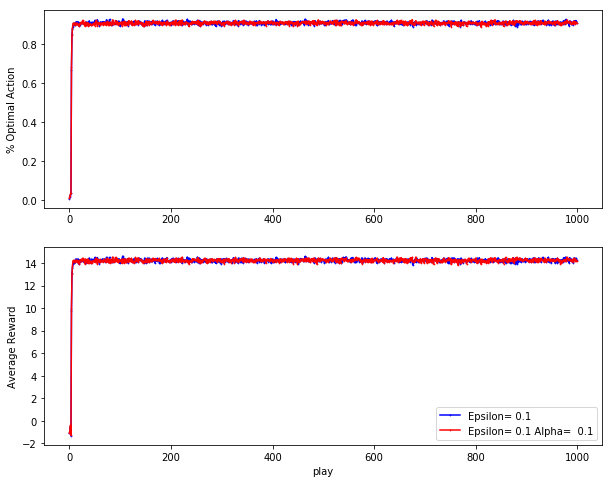

In [90]:
plotResults(sample)

They both have slightly the same outcome because there are 10 arms in our enviorment so the step size of sample-average is close to 0.1.

## Optimistic Initial Values

We can force our agent to explore in the beginning and then let it exploit (either Greedy or EpsilonGreedy). But when our environment is non-stationary this is not a good idea because maybe in future there will be a better action due to changing situation. But for now we are sampling stationary cases. If we assign our initial action values to 5 instead of zero, recalling that our environment reward mean is zero and variance is one so this claim is really optimistic, but this optimism encourages action-value methods to explore. Whichever actions are initially selected, the reward is less than the starting estimates; the learner switches to other actions, being “disappointed” with the rewards it is receiving. The result is that all actions are tried several times before the value estimates converge. The system does a fair amount of exploration even if greedy actions are selected all the time.

In [38]:
class OptimisticAgent():
    
    def __init__(self, armCount, epsilon = 0.1, alpha = 0.1, initVal = 5):
        self.values = np.zeros(armCount)
        self.initVal = initVal # initial value given for OptimisticAgent
        self.values.fill(self.initVal)
        self.pullCount = np.zeros(armCount)
        self.choice = np.arange(armCount)
        self.armCount = armCount
        self.epsilon = epsilon
        self.alpha = alpha

    def __repr__(self):
        return "Optimistic " + (("Epsilon= " + str(self.epsilon)) if self.epsilon > 0 else "Greedy")

    def selectArm(self):
        if np.random.rand() > self.epsilon: # Exploit
            return np.argmax(self.values)
        else: # Explore
            return np.random.choice(self.choice)

    def update(self, i, reward):
        self.pullCount[i] += 1
        count = self.pullCount[i]
        value = self.values[i]
        # newEstimate = oldEstimate + step_size * (target - oldEstimate)
        self.values[i] = value + (self.alpha) * (reward - value)

    def refresh(self):
        self.values.fill(self.initVal)
        self.pullCount.fill(0)

In [39]:
agents = [OptimisticAgent(env.armCount, 0.1), OptimisticAgent(env.armCount, 0.0), EpsilonGreedyAgent(env.armCount, 0.1)]
sample = Sampling(env, agents)
sample.start()

100%|██████████| 2000/2000 [00:52<00:00, 38.11it/s]


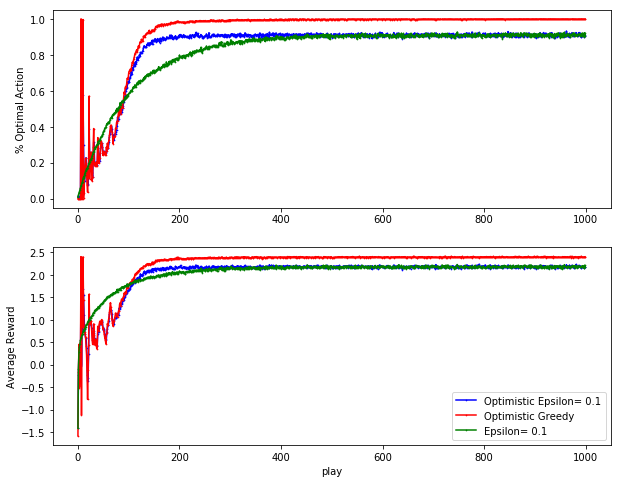

In [40]:
plotResults(sample)

Both of optimistic agents had constant step size of 0.1, and at first optimistic agents are doing poorly due to their exploring but after around 190 plays both of them are superior to realestic agent because they found the best action and now they are exploiting it. The reason why greedy optiimistic agent is doing better is that this enviorment is stationary.

## Reinforcement Comparison

## Pursuit Methods